In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import scipy
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_mixture_batches
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel

def get_param(model, show=True):
    para = model.get_model_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

# Loading LEiDA

In [3]:
fmri_dataset = '../data/dataset/dataset_all_subjects_LEiDA.hdf5'
dataf = h5py.File(fmri_dataset, mode='r')

num_subjects = len(list(dataf.keys()))
seq_len = 330
obs_dim = 90

leida_full = torch.zeros(num_subjects,seq_len,obs_dim)

for idx, subject in enumerate(list(dataf.keys())):
    leida_full[idx] = torch.tensor(np.array(dataf[subject]))
    
print(leida_full.shape)

torch.Size([199, 330, 90])


## Show LEIDA vectors

In [261]:
label = pd.read_csv(f"task_processing/AALlabels.csv")
label = [i[0][1:-1] for i in label.values]

<function matplotlib.pyplot.show(close=None, block=None)>

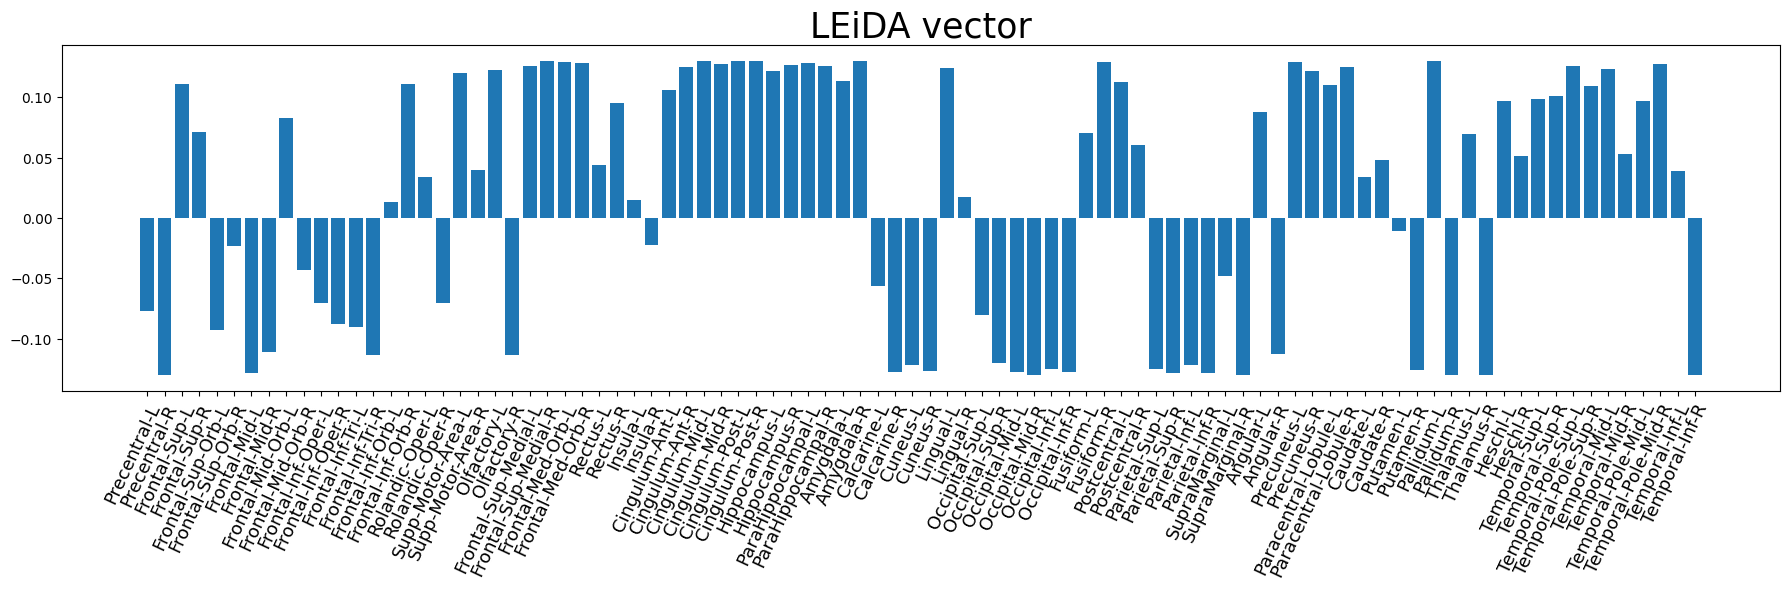

In [295]:
v = leida_full[0,50]
fig, ax = plt.subplots(figsize=(18,4))
im = ax.bar(label, v)
fig.tight_layout()
ax.set_title('LEiDA vector', size=25)
ax.set_xticks(np.arange(len(label)), labels=label, size=13)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",rotation_mode="anchor")

plt.show

In [4]:
#only the first 50 subjects
leida_50 = leida_full[:50]
print(leida_50.shape)
leida_50_train = leida_50[:,:int(seq_len/2),:]
leida_50_test = leida_50[:,int(seq_len/2):,:]
print(leida_50_train.shape)
print(leida_50_test.shape)

leida_bat = torch.cat(tuple([*leida_50_train]),0)
leida_bat.shape

torch.Size([50, 330, 90])
torch.Size([50, 165, 90])
torch.Size([50, 165, 90])


torch.Size([8250, 90])

# ACG Mixture

In [42]:
model_dist = ACG

In [29]:
acgtest = TorchMixtureModel(model_dist, K=7, dist_dim=obs_dim)

### Waton Mixture best learning rate

In [40]:
int_epoch = 100
Adam_optimizer = optim.Adam(acgtest.parameters(), lr=0.1)
epoch_likelihood = train_mixture_batches(acgtest, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

  0%|          | 0/100 [00:00<?, ?it/s]

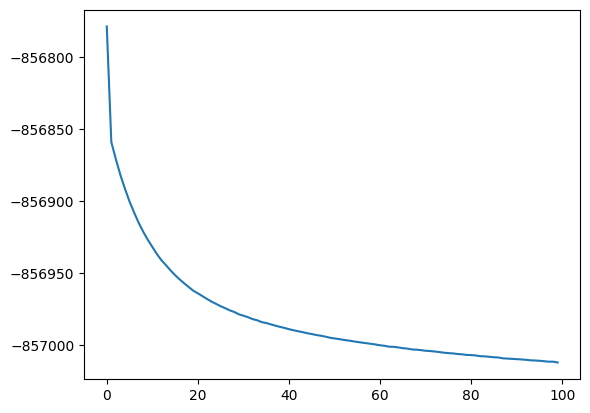

-857012.1875


In [43]:
plt.close()
%matplotlib inline
plt.plot(epoch_likelihood)
plt.show()
print(epoch_likelihood[-1])

In [80]:
cluster_eval = np.arange(5,15)
cluster_eval

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [83]:
LR_eval = np.arange(0.01,1.5,0.08)
LR_eval

array([0.01, 0.09, 0.17, 0.25, 0.33, 0.41, 0.49, 0.57, 0.65, 0.73, 0.81,
       0.89, 0.97, 1.05, 1.13, 1.21, 1.29, 1.37, 1.45])

In [86]:
int_epoch = 300

lr_results = np.zeros((len(LR_eval),int_epoch))
best_like = -1e+5

for idx, LR in enumerate(tqdm(LR_eval)):

    acg_model = TorchMixtureModel(ACG, K=10, dist_dim=obs_dim) #New init of model

    Adam_optimizer = optim.Adam(acg_model.parameters(), lr=LR)
    model_like = train_mixture(acg_model, data=leida_bat, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

    lr_results[idx] = model_like

    if model_like[-1] < best_like:
        best_model = Watson_model
        best_like = model_like[-1]
        best_idx = idx

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

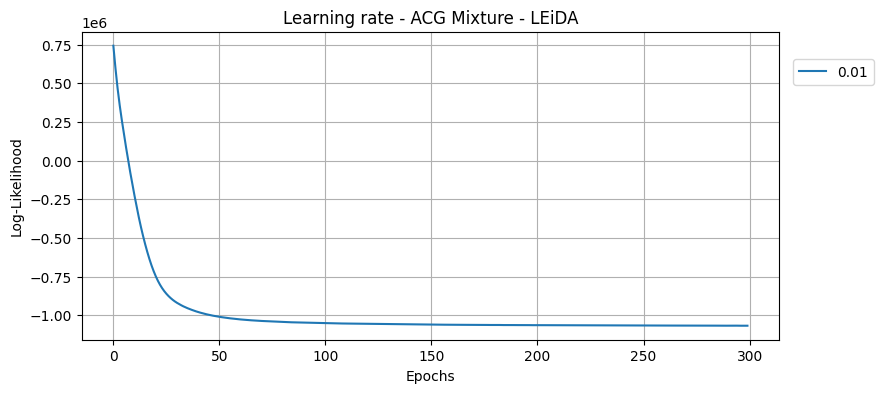

In [97]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(lr_results[1].T)
plt.title('Learning rate - ACG Mixture - LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(LR_eval,3), ncol=2, bbox_to_anchor=(1.02, .91), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [91]:
best_like

-1068480.375

In [103]:
int_epoch = 125
runs = 2
cluster_results = np.zeros((runs, len(cluster_eval),int_epoch))
LR = .09
best_like = -1e+5


for run_i in range(runs):
    for idx, cluster in enumerate(tqdm(cluster_eval)):

        acg_model = TorchMixtureModel(ACG, K=cluster, dist_dim=obs_dim) #New init of model

        Adam_optimizer = optim.Adam(acg_model.parameters(), lr=LR)
        model_like = train_mixture(acg_model, data=leida_bat, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

        cluster_results[run_i, idx] = model_like

        if model_like[-1] < best_like:
            best_model = Watson_model
            best_like = model_like[-1]
            best_idx = idx

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

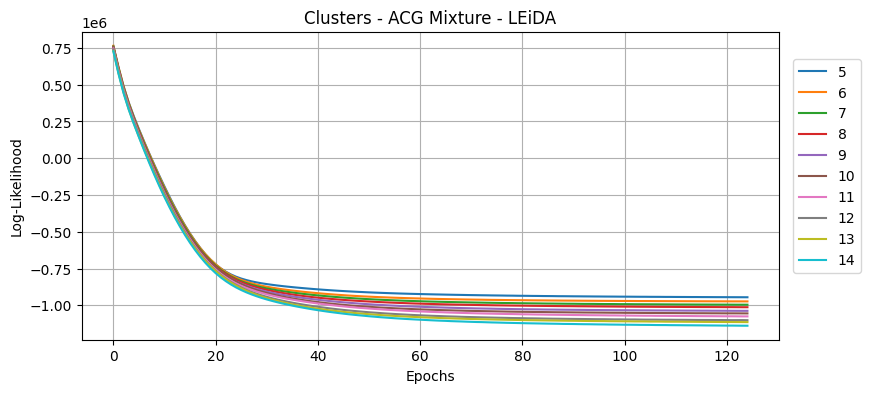

In [104]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(cluster_results.mean(0).T)
plt.title('Clusters - ACG Mixture - LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(cluster_eval, ncol=1, bbox_to_anchor=(1.02, .91), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [101]:
print(best_like)

-1075393.5


In [48]:
cluster_results[:,:,-1]

array([[-827829.4375, -827435.3125, -832042.6875, -829304.625 ,
        -827615.3125, -829640.9375, -830762.4375, -830550.625 ,
        -838696.75  , -829429.6875],
       [-828840.375 , -830987.5625, -831462.5   , -829676.0625,
        -831617.8125, -827509.8125, -832933.5625, -829587.0625,
        -831406.5625, -830998.8125]])

In [25]:
cluster_results[:,:,-1].std(0)

array([ 311.69098128,  111.68945787,  208.79747065,  202.64550559,
        164.87162335,  130.18499698, 7153.57617937,  162.56816839,
         49.43664822, 6464.65344542])

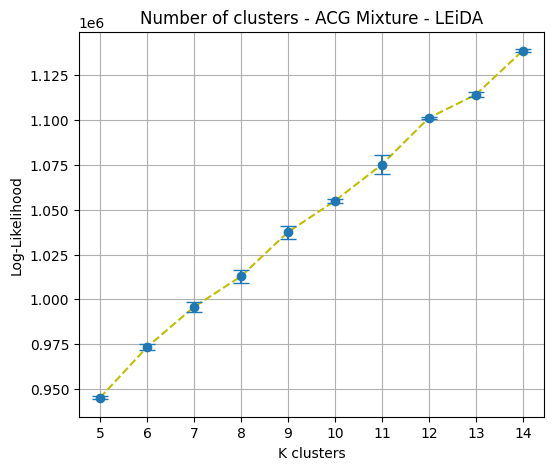

In [105]:
mean_results = cluster_results[:,:,-1].mean(0)
std_results = cluster_results[:,:,-1].std(0)

plt.close()
%matplotlib inline
plt.figure(figsize=(6, 5))
plt.plot(cluster_eval, -mean_results, '--y')
plt.errorbar(cluster_eval,-mean_results, yerr=std_results, capsize=6,fmt='o', ls='none')
plt.title('Number of clusters - ACG Mixture - LEiDA')
plt.xlabel('K clusters')
plt.ylabel('Log-Likelihood')
plt.xticks([*cluster_eval])
#plt.legend(cluster_eval, ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

#### Train with best K=10 ACG mixture

In [111]:
eval_LR = [0.1]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

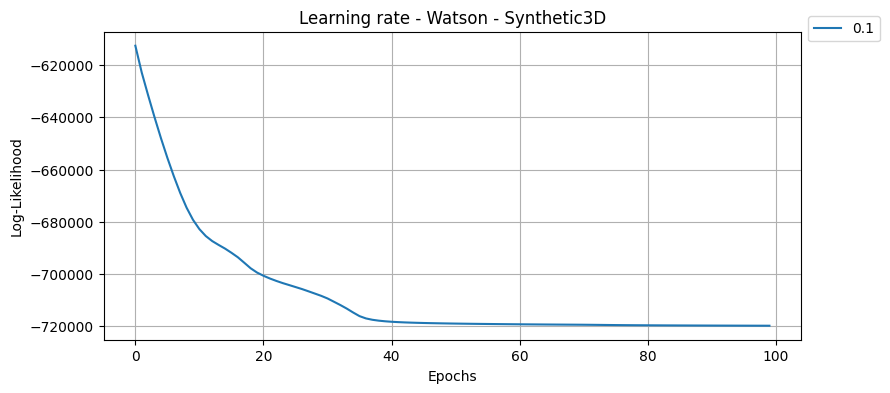

In [112]:
int_epoch = 100
LR_results = np.zeros((len(eval_LR),int_epoch))
model_dist = ACG
for idx, LR in enumerate(tqdm(eval_LR)):
    watson7 = TorchMixtureModel(model_dist, K=9, dist_dim=90) #New init of model
    Adam_optimizer = optim.Adam(watson7.parameters(), lr=LR)
    LR_results[idx] = train_mixture_batches(watson7, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

    
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(LR_results.T)
plt.title('Learning rate - ACG - LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(eval_LR, 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [113]:
argmin = np.argmin(LR_results[:,-1])
watson_best_likelihood = LR_results[argmin,-1]
watson_best_LR = eval_LR[argmin]
print(f'Max LL: {-watson_best_likelihood}')
print(f'Using learning rate: {watson_best_LR}')

Max LL: 719755.5
Using learning rate: 0.1


# Hidden Markov Model | Angular Central Gaussian | LEiDA

In [112]:
%matplotlib notebook
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_hmm, train_hmm_subjects
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from models.HMM.HMM_torch import HiddenMarkovModel as HMM
from data.synthetic_generator import syntheticHMM
import scipy

In [113]:
print(leida_50_train.shape)
print(leida_50_test.shape)
model_dist = ACG

torch.Size([50, 165, 90])
torch.Size([50, 165, 90])


In [110]:
hmmacgtest = HMM(num_states=6, observation_dim=obs_dim, emission_dist=model_dist)

#_ = get_param(hmmacgtest)

In [123]:
device = 'cpu'
Adam_optimizer = optim.Adam(hmmacgtest.parameters(), lr=0.09)
epoch_like = train_hmm(hmmacgtest, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=100, keep_bar=True, dev=device)

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


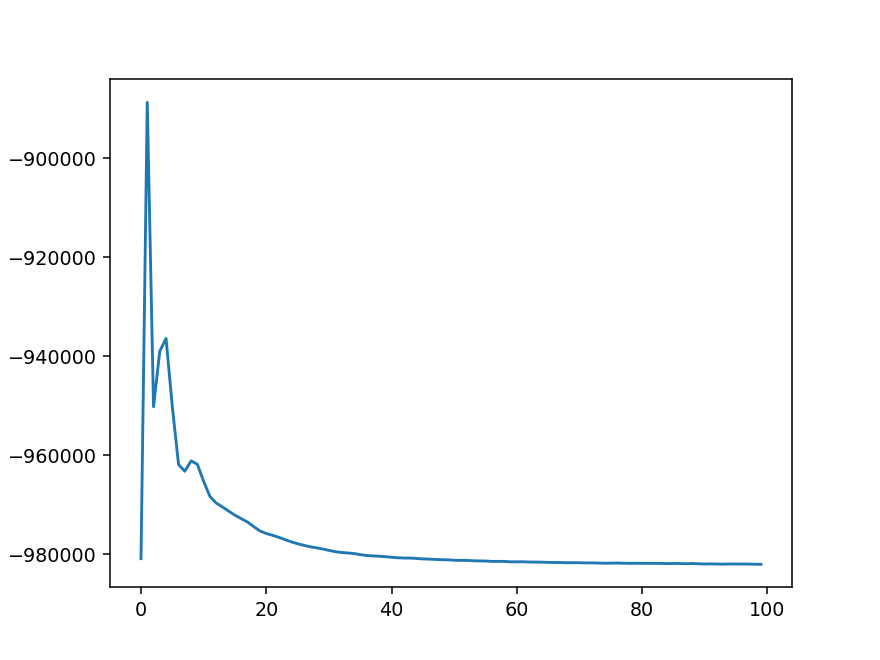

In [124]:
plt.plot(epoch_like)
plt.show()
print()

In [125]:
hmm_eval_LR = np.arange(0.08, 1, 0.08)
print(hmm_eval_LR)

[0.08 0.16 0.24 0.32 0.4  0.48 0.56 0.64 0.72 0.8  0.88 0.96]


In [ ]:
int_epoch = 150
acg_lr_res = np.zeros((len(hmm_eval_LR),int_epoch))

for idx, LR in enumerate(tqdm(hmm_eval_LR)):
    acg_hmm = HMM(num_states=10, observation_dim=90, emission_dist=ACG) #New init of model
    Adam_optimizer = optim.Adam(acg_hmm.parameters(), lr=LR)
    acg_lr_res[idx] = train_hmm(acg_hmm, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)


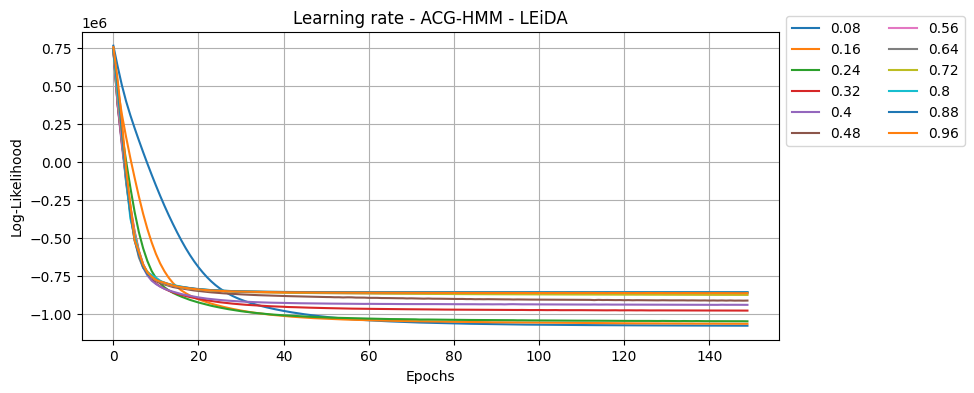

In [130]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(acg_lr_res.T)
plt.title('Learning rate - ACG-HMM - LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(hmm_eval_LR, 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [129]:
acg_lr_res[:,-1]

array([-1076143.75  , -1063458.375 , -1047160.0625,  -976827.0625,
        -938998.125 ,  -910932.125 ,  -870248.    ,  -857163.75  ,
        -873629.125 ,  -857163.625 ,  -857163.5   ,  -861709.25  ])

In [256]:
cluster_eval = np.arange(5,21)
cluster_eval

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [257]:
int_epoch = 100

cluster_results = np.zeros((len(cluster_eval),int_epoch))
LR = .08
best_like = -1e+5

for idx, cluster in enumerate(tqdm(cluster_eval)):

    acg_hmm = HMM(num_states=cluster, observation_dim=90, emission_dist=ACG) #New init of model
    Adam_optimizer = optim.Adam(acg_hmm.parameters(), lr=LR)
    model_like = train_hmm(acg_hmm, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

    cluster_results[idx] = model_like

    if model_like[-1] < best_like:
        best_model = Watson_model
        best_like = model_like[-1]
        best_idx = idx
    if cluster == 9:
        model9 = acg_hmm

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

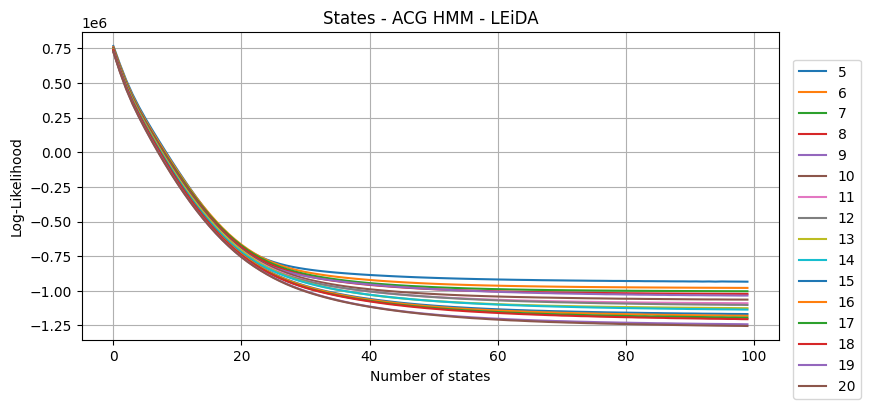

{5: -934087.875, 6: -978969.25, 7: -1003155.75, 8: -1022394.75, 9: -1034155.0, 10: -1063494.5, 11: -1089477.25, 12: -1101832.25, 13: -1125299.75, 14: -1135533.625, 15: -1167755.375, 16: -1180316.375, 17: -1193656.125, 18: -1204507.375, 19: -1241549.625, 20: -1253787.75}


In [258]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(cluster_results.T)
plt.title('States - ACG HMM - LEiDA')
plt.xlabel('Number of states')
plt.ylabel('Log-Likelihood')
plt.legend(cluster_eval, ncol=1, bbox_to_anchor=(1.02, .91), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()
print(dict(zip(cluster_eval,cluster_results[:,-1])))

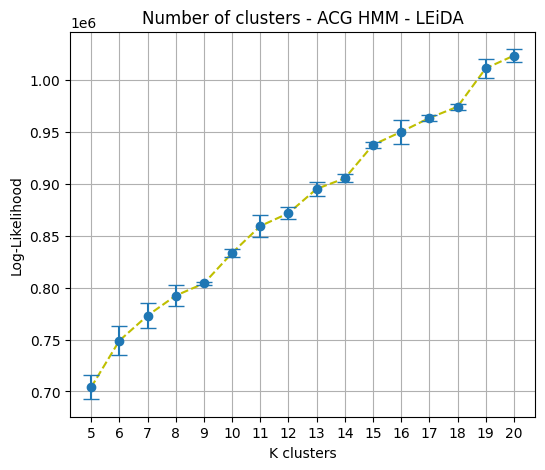

In [305]:
plt.close()
%matplotlib inline
plt.figure(figsize=(6, 5))
plt.plot(cluster_eval, -cluster_results[:,-1], '--y')
plt.errorbar(cluster_eval,-cluster_results[:,-1], yerr=std_results, capsize=6,fmt='o', ls='none')
plt.title('Number of clusters - ACG HMM - LEiDA')
plt.xlabel('K clusters')
plt.ylabel('Log-Likelihood')
plt.xticks([*cluster_eval])
#plt.legend(cluster_eval, ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

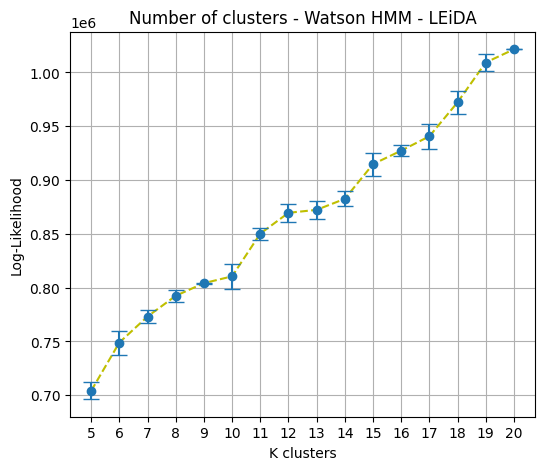

In [323]:
plt.close()
%matplotlib inline
plt.figure(figsize=(6, 5))
plt.plot(cluster_eval, x, '--y')
plt.errorbar(cluster_eval,x, yerr=std_results, capsize=6,fmt='o', ls='none')
plt.title('Number of clusters - Watson HMM - LEiDA')
plt.xlabel('K clusters')
plt.ylabel('Log-Likelihood')
plt.xticks([*cluster_eval])
#plt.legend(cluster_eval, ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [329]:
acg_param = get_param(model9)
t = acg_param['un_norm_Transition_matrix']

un_norm_priors
tensor([-2.5968, -0.3309,  1.0478, -2.4473,  3.2639, -0.6147, -2.5379,  0.6939,
         0.8199])
------------------------------
un_norm_Transition_matrix
tensor([[ 2.7715, -2.2699, -2.5274, -2.4852, -0.1575, -3.1188, -2.9591, -2.0347,
         -1.6967],
        [-2.7969,  3.4056, -2.3239, -2.7757,  0.4736, -2.4823, -1.7314, -1.8693,
         -1.8228],
        [-1.9728, -1.9822,  3.3381, -3.0266,  0.3007, -2.8001, -2.4989, -2.1609,
         -2.1697],
        [-1.6267, -1.9845, -1.8422,  2.2131, -1.1975, -1.4860, -2.0202, -1.1370,
         -1.5494],
        [-2.0798, -2.3886, -1.2916, -3.1338,  3.1488, -2.6721, -2.6571, -2.1506,
         -1.3788],
        [-2.2283, -1.7573, -1.2602, -2.4189, -0.4069,  2.7085, -1.7186, -2.3926,
         -1.7569],
        [-1.4965, -1.6540, -1.6856, -2.5310,  0.3495, -2.6660,  3.0711, -2.5471,
         -1.5412],
        [-2.1719, -2.1810, -2.1969, -2.4023,  0.3896, -2.7108, -2.0807,  3.3431,
         -1.5293],
        [-2.0429, -2.3817, -1.

In [177]:
a = torch.randn(3,3)
a

tensor([[-1.0267,  0.4316,  0.5065],
        [-1.2356, -0.8781, -0.5973],
        [ 1.8884, -0.3425,  0.7525]])

In [179]:
a.softmax(dim=1)

tensor([[0.1007, 0.4328, 0.4665],
        [0.2313, 0.3307, 0.4379],
        [0.7000, 0.0752, 0.2248]])

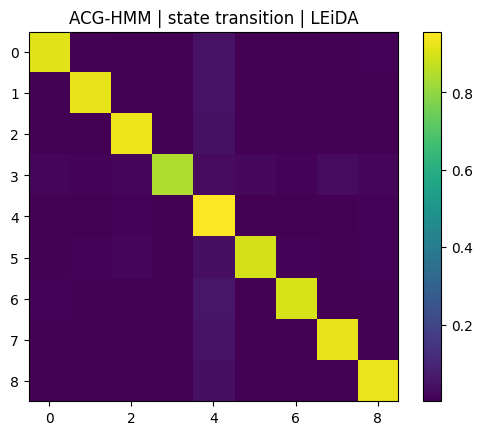

In [333]:
fig, ax = plt.subplots()
im = ax.imshow(t.softmax(dim=1))
fig.tight_layout
plt.colorbar(im,ax=ax)
plt.title('ACG-HMM | state transition | LEiDA')
plt.show()

### Train another

  0%|          | 0/150 [00:00<?, ?it/s]

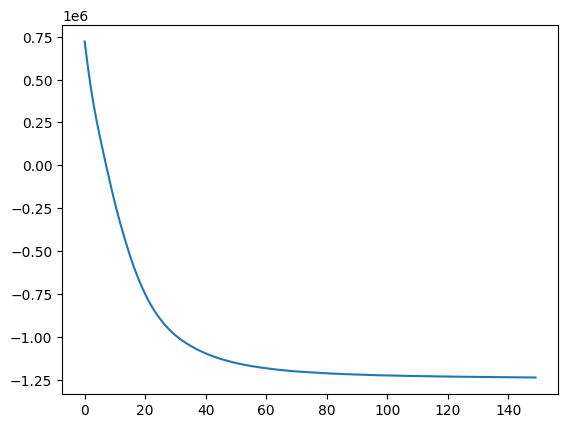

-1235908.5


In [195]:
acg_hmm = HMM(num_states=18, observation_dim=90, emission_dist=ACG) #New init of model
Adam_optimizer = optim.Adam(acg_hmm.parameters(), lr=0.08)
model_like = train_hmm(acg_hmm, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=150, keep_bar=False)
plt.close()
plt.plot(model_like)
plt.show()
print(model_like[-1])

## Viterbi decode - ACG

In [336]:
best_paths, paths_probs = acg_hmm.viterbi2(leida_full[4:9])

In [325]:
task = np.array([-0.077266  , -0.077266  , -0.077266  , -0.077266  , -0.077266  ,
       -0.077266  , -0.077266  , -0.077266  , -0.07519356, -0.04446375,
        0.06366555,  0.2727299 ,  0.54056387,  0.77666261,  0.91019346,
        0.922734  ,  0.83758388,  0.69474512,  0.53363728,  0.40683975,
        0.3749293 ,  0.44177659,  0.54258737,  0.60716048,  0.60246426,
        0.53314361,  0.42333585,  0.30169185,  0.21468549,  0.22207521,
        0.35114093,  0.55893504,  0.75207337,  0.85635188,  0.85029649,
        0.75473443,  0.60981205,  0.47793914,  0.43260242,  0.51018051,
        0.67243923,  0.82762718,  0.90145395,  0.87163454,  0.75802665,
        0.5978146 ,  0.42813397,  0.29988006,  0.27164742,  0.34583311,
        0.45610116,  0.53143215,  0.53785572,  0.47930814,  0.37943976,
        0.26661162,  0.18716949,  0.2010967 ,  0.33544355,  0.54718268,
        0.74340405,  0.85004524,  0.84576837,  0.75152321,  0.6075612 ,
        0.4763788 ,  0.43176303,  0.50983952,  0.67243923,  0.82762718,
        0.90145395,  0.87163454,  0.75802665,  0.5978146 ,  0.42813397,
        0.29988006,  0.27164742,  0.34583311,  0.45610116,  0.53143215,
        0.53785572,  0.47930814,  0.37943976,  0.26661162,  0.18716949,
        0.2010967 ,  0.33544355,  0.54718268,  0.74340405,  0.85004524,
        0.84576837,  0.75152321,  0.6075612 ,  0.4763788 ,  0.43176303,
        0.50983952,  0.67243923,  0.82762718,  0.90145395,  0.87163454,
        0.75802665,  0.5978146 ,  0.42813397,  0.29988006,  0.27164742,
        0.34583311,  0.45610116,  0.53143215,  0.53785572,  0.47930814,
        0.37943976,  0.26661162,  0.18716949,  0.2010967 ,  0.33544355,
        0.54718268,  0.74340405,  0.85004524,  0.84576837,  0.75152321,
        0.6075612 ,  0.4763788 ,  0.43176303,  0.50983952,  0.67243923,
        0.82762718,  0.90145395,  0.87163454,  0.75802665,  0.5978146 ,
        0.42813397,  0.29988006,  0.27164742,  0.34583311,  0.45610116,
        0.53143215,  0.53785572,  0.47930814,  0.37943976,  0.26661162,
        0.18716949,  0.2010967 ,  0.33544355,  0.54718268,  0.74340405,
        0.85004524,  0.84576837,  0.75152321,  0.6075612 ,  0.4763788 ,
        0.43176303,  0.50983952,  0.67243923,  0.82762718,  0.90145395,
        0.87163454,  0.75802665,  0.5978146 ,  0.42813397,  0.29988006,
        0.27164742,  0.34583311,  0.45610116,  0.53143215,  0.53785572,
        0.47930814,  0.37943976,  0.26661162,  0.18716949,  0.2010967 ,
        0.33544355,  0.54718268,  0.74340405,  0.85004524,  0.84576837,
        0.75152321,  0.6075612 ,  0.4763788 ,  0.43176303,  0.50983952,
        0.67243923,  0.82762718,  0.90145395,  0.87163454,  0.75802665,
        0.5978146 ,  0.42813397,  0.29988006,  0.27164742,  0.34583311,
        0.45610116,  0.53143215,  0.53785572,  0.47930814,  0.37943976,
        0.26661162,  0.18716949,  0.2010967 ,  0.33544355,  0.54718268,
        0.74340405,  0.85004524,  0.84576837,  0.75152321,  0.6075612 ,
        0.4763788 ,  0.43176303,  0.50983952,  0.67243923,  0.82762718,
        0.90145395,  0.87163454,  0.75802665,  0.5978146 ,  0.42813397,
        0.29988006,  0.27164742,  0.34583311,  0.45610116,  0.53143215,
        0.53785572,  0.47930814,  0.37943976,  0.26661162,  0.18716949,
        0.2010967 ,  0.33544355,  0.54718268,  0.74340405,  0.85004524,
        0.84576837,  0.75152321,  0.6075612 ,  0.4763788 ,  0.43176303,
        0.50983952,  0.67243923,  0.82762718,  0.90145395,  0.87163454,
        0.75802665,  0.5978146 ,  0.42813397,  0.29988006,  0.27164742,
        0.34583311,  0.45610116,  0.53143215,  0.53785572,  0.47930814,
        0.37943976,  0.26661162,  0.18716949,  0.2010967 ,  0.33544355,
        0.54718268,  0.74340405,  0.85004524,  0.84576837,  0.75152321,
        0.6075612 ,  0.4763788 ,  0.43176303,  0.50983952,  0.67243923,
        0.82762718,  0.90145395,  0.87163454,  0.75802665,  0.5978146 ,
        0.42813397,  0.29988006,  0.27164742,  0.34583311,  0.45610116,
        0.53143215,  0.53785572,  0.47930814,  0.37943976,  0.26661162,
        0.18716949,  0.2010967 ,  0.33544355,  0.54718268,  0.74340405,
        0.85004524,  0.84576837,  0.75152321,  0.6075612 ,  0.4763788 ,
        0.43176303,  0.50983952,  0.67243923,  0.82762718,  0.90145395,
        0.87163454,  0.75802665,  0.5978146 ,  0.42813397,  0.29988006,
        0.27164742,  0.34583311,  0.45610116,  0.53143215,  0.53785572,
        0.47930814,  0.37943976,  0.26661162,  0.18716949,  0.2010967 ,
        0.33544355,  0.54718268,  0.74340405,  0.85004524,  0.84576837,
        0.75152321,  0.60548876,  0.44357655,  0.29083148,  0.15984362,
        0.05460936, -0.02630143, -0.08600551, -0.12836546, -0.15682322,
       -0.17419651, -0.18276931, -0.18422569, -0.18054787, -0.17320948])

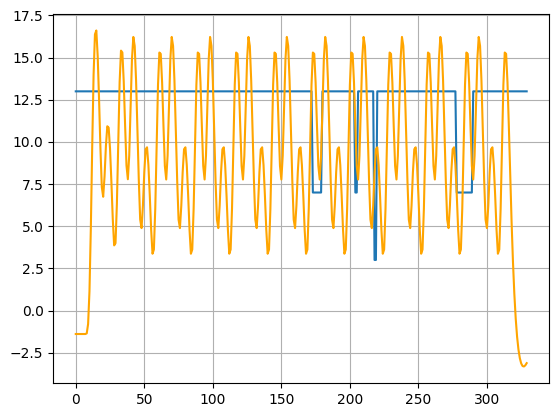

In [328]:
plt.plot(best_paths[19])
plt.plot(task*18, c='orange')
plt.grid()
plt.show()

In [233]:
import pandas as pd
import math
events = pd.read_csv("task_processing/events/sub-0001/func/sub-0001_task-faces_acq-mb3_events.tsv",sep='\t',header=0)
start = np.array(events.onset*4/3)
end = np.array((events.onset+2)*4/3)
start

array([  6.66706667,  16.00173333,  25.3364    ,  34.67773333,
        44.0124    ,  53.34706667,  62.68173333,  72.0164    ,
        81.35106667,  90.68573333, 100.0204    , 109.35506667,
       118.68973333, 128.0244    , 137.35906667, 146.69373333,
       156.0284    , 165.36306667, 174.69773333, 184.0324    ,
       193.36706667, 202.70173333, 212.0364    , 221.37106667,
       230.70573333, 240.0404    , 249.37506667, 258.70973333,
       268.0444    , 277.37906667, 286.71373333, 296.0484    ,
       305.38306667])

In [242]:

Labels = np.zeros([330])
for j in range(len(start)):

    idx = math.ceil(start[j])

    while idx < end[j]:
        Labels[idx] = 1
        idx += 1

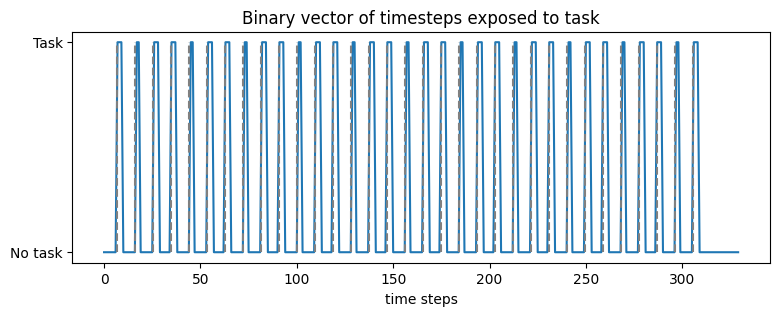

In [243]:
plt.figure(figsize=(9,3))
plt.plot(Labels)
plt.yticks([0,1],["No task","Task"])
plt.title("Binary vector of timesteps exposed to task")
plt.xlabel("time steps")
plt.vlines(start, 0, 1, linestyles ="dashed", colors ="gray")

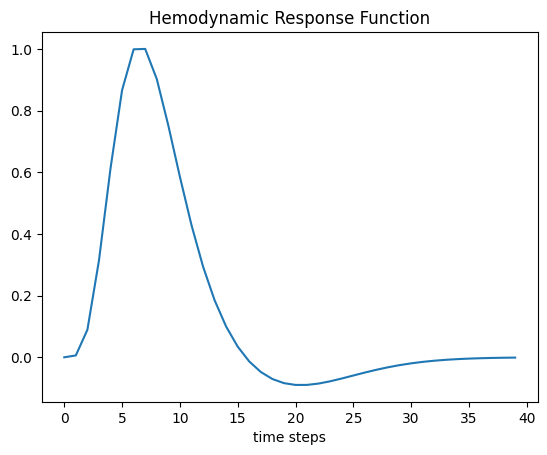

C:\Users\Ortva\AppData\Local\Temp\ipykernel_18252\1803086393.py:13: RuntimeWarning: invalid value encountered in divide
  LabelsC = np.array([(LabelsC[i] - LabelsC[i].mean())/(LabelsC[i].max())+1/2 for i in range(Labels.shape[0])])


(330, 40)

In [250]:
import hrf_estimation as he
from scipy import signal
plt.close()
xx = np.linspace(0, 30,num=int(30*4/3))
hrf = he.hrf.spmt(xx)
plt.plot(hrf)
plt.xlabel("time steps")
plt.title("Hemodynamic Response Function")
plt.show()

LabelsC = [np.convolve(Labels[i],hrf, mode = "full")[0:330] for i in range(Labels.shape[0])]

LabelsC = np.array([(LabelsC[i] - LabelsC[i].mean())/(LabelsC[i].max())+1/2 for i in range(Labels.shape[0])])
LabelsC.shape

## Train a Watson

In [ ]:
watson_hmm = HMM(num_states=18, observation_dim=90, emission_dist=Watson) #New init of model

  0%|          | 0/150 [00:00<?, ?it/s]

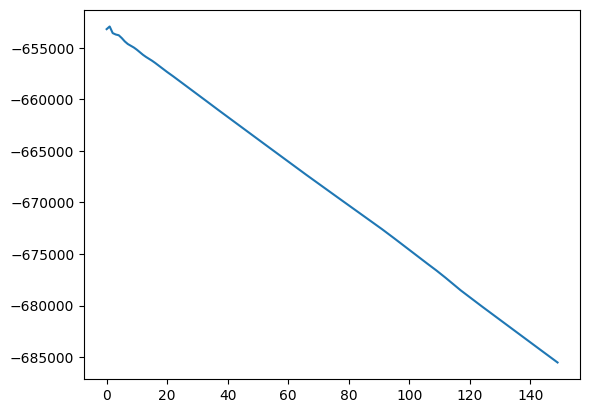

-685522.0


In [213]:
Adam_optimizer = optim.Adam(watson_hmm.parameters(), lr=0.8)
model_like = train_hmm(watson_hmm, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=50, keep_bar=False)
plt.close()
plt.plot(model_like)
plt.show()
print(model_like[-1])

IndexError: index 2 is out of bounds for axis 0 with size 2

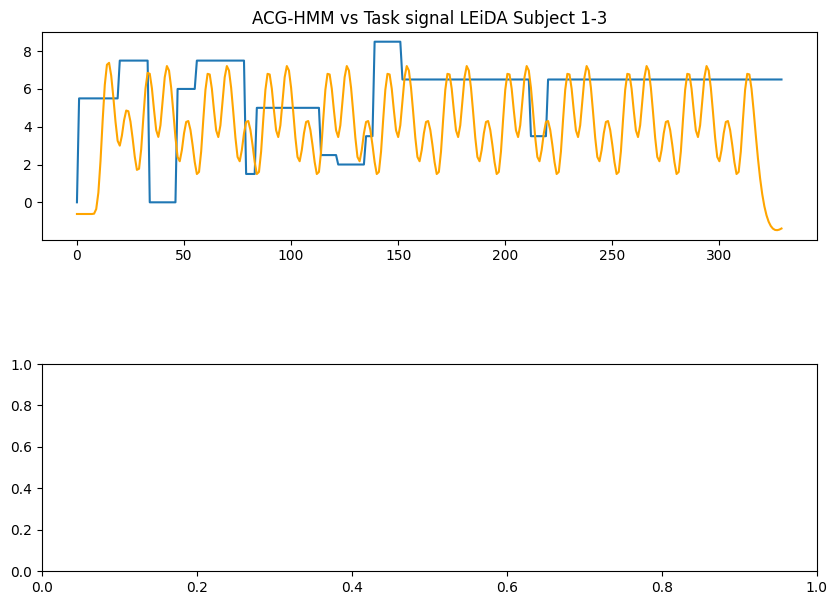

In [350]:
sub = 1
decode_path = list(best_paths[sub])
decode_path.insert(0,0) # shift correnction
plt.close()
fig, ax = plt.subplots(2,1, figsize=(10,7))
fig.subplots_adjust(hspace=0.6)

for sub in range(1):
    decode_path = list(best_paths[sub]/2)
    decode_path.insert(0,0) # shift correnction
    ax[sub].plot(decode_path[:-1], label='Decode')
    ax[sub].plot(task*8, c='orange')
    #ax[sub].yticks([0,1,2])
    ax[0].set_title('ACG-HMM vs Task signal LEiDA Subject 1-3')
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
               ncol=2)

plt.show()

<IPython.core.display.Javascript object>


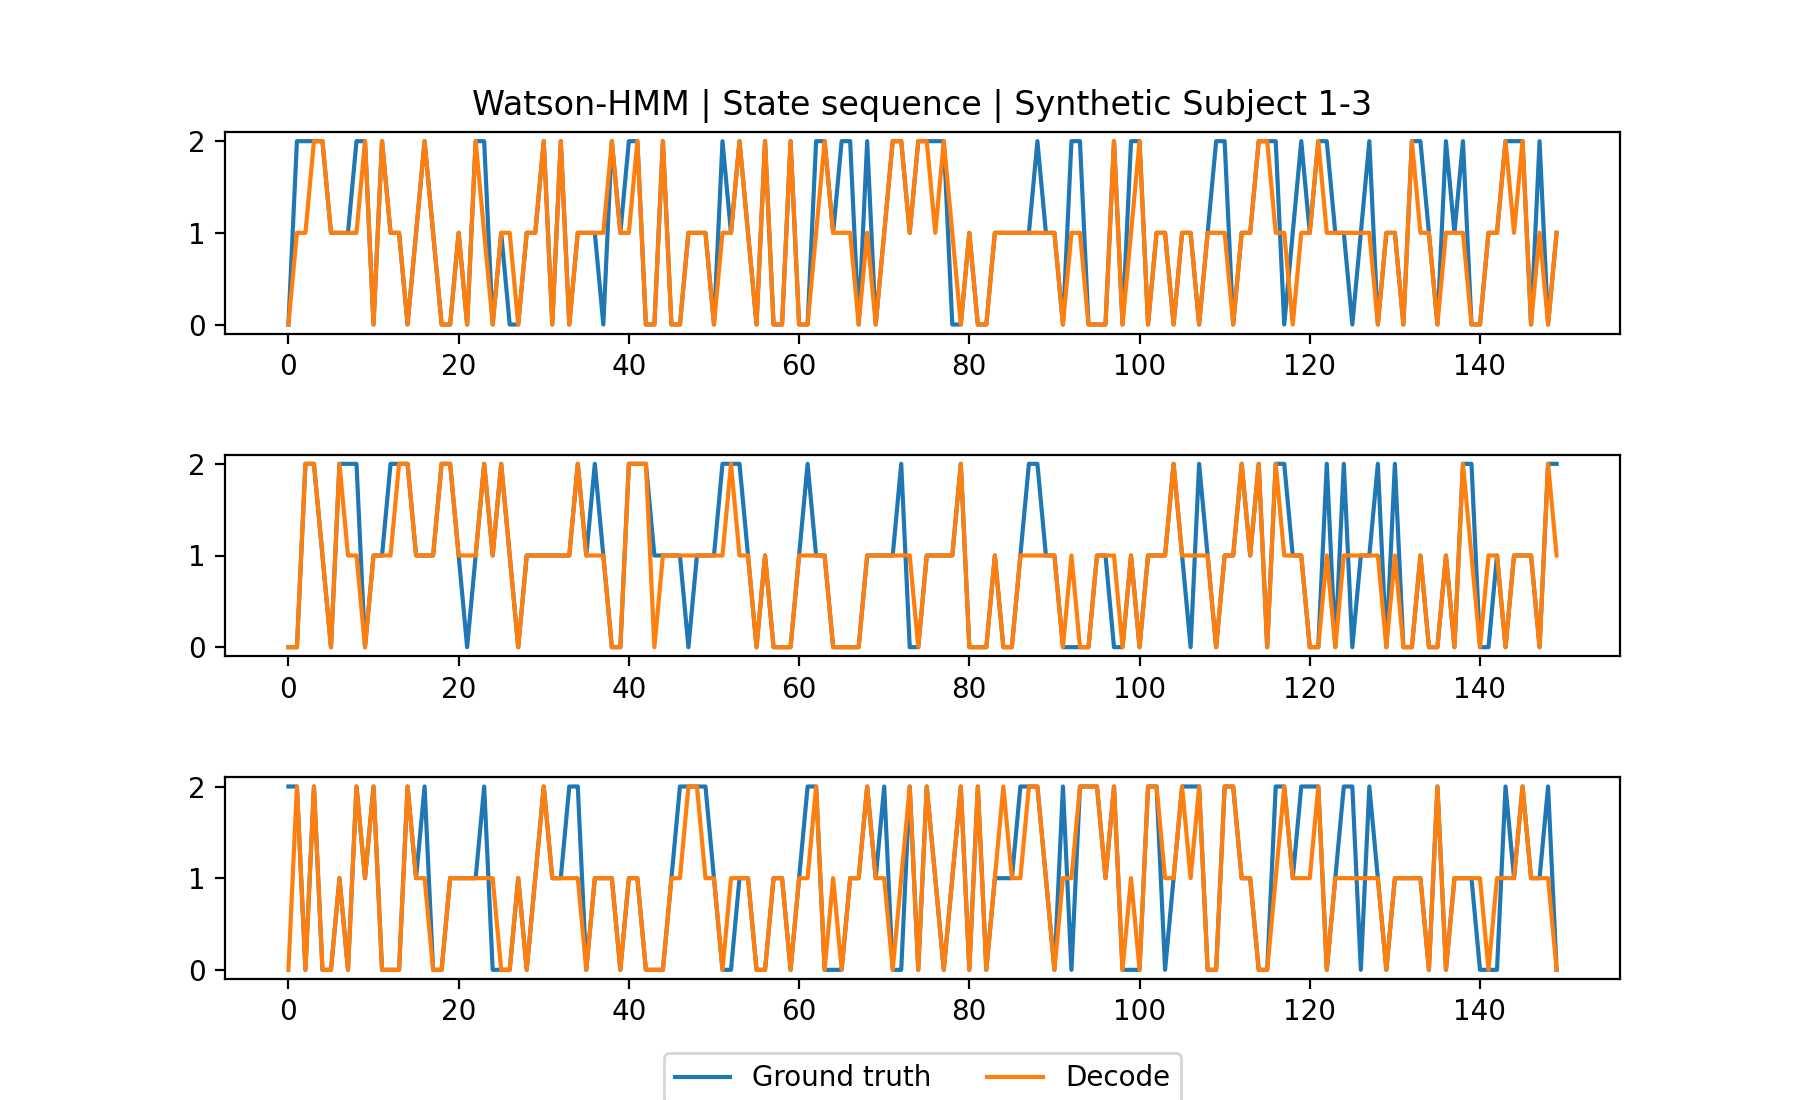

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [232]:
sub = 4
decode_path = list(best_paths[sub])
decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
decode_path.insert(0,0) # shift correnction
plt.close()
fig, ax = plt.subplots(3,1, figsize=(9,5.5))
fig.subplots_adjust(hspace=0.6)

for sub in range(3):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    ax[sub].plot(Z_seq[sub], label='Ground truth')
    ax[sub].plot(decode_path[:-1], label='Decode')
    #ax[sub].yticks([0,1,2])
    ax[0].set_title('Watson-HMM | State sequence | Synthetic Subject 1-3')
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
               ncol=2)

plt.show()

## Watson-HMM | NMI score

In [117]:
from sklearn.metrics import normalized_mutual_info_score as NMI

In [228]:
NMI(Z_seq[sub],decode_path[:-1])

0.5397459496727025

<IPython.core.display.Javascript object>


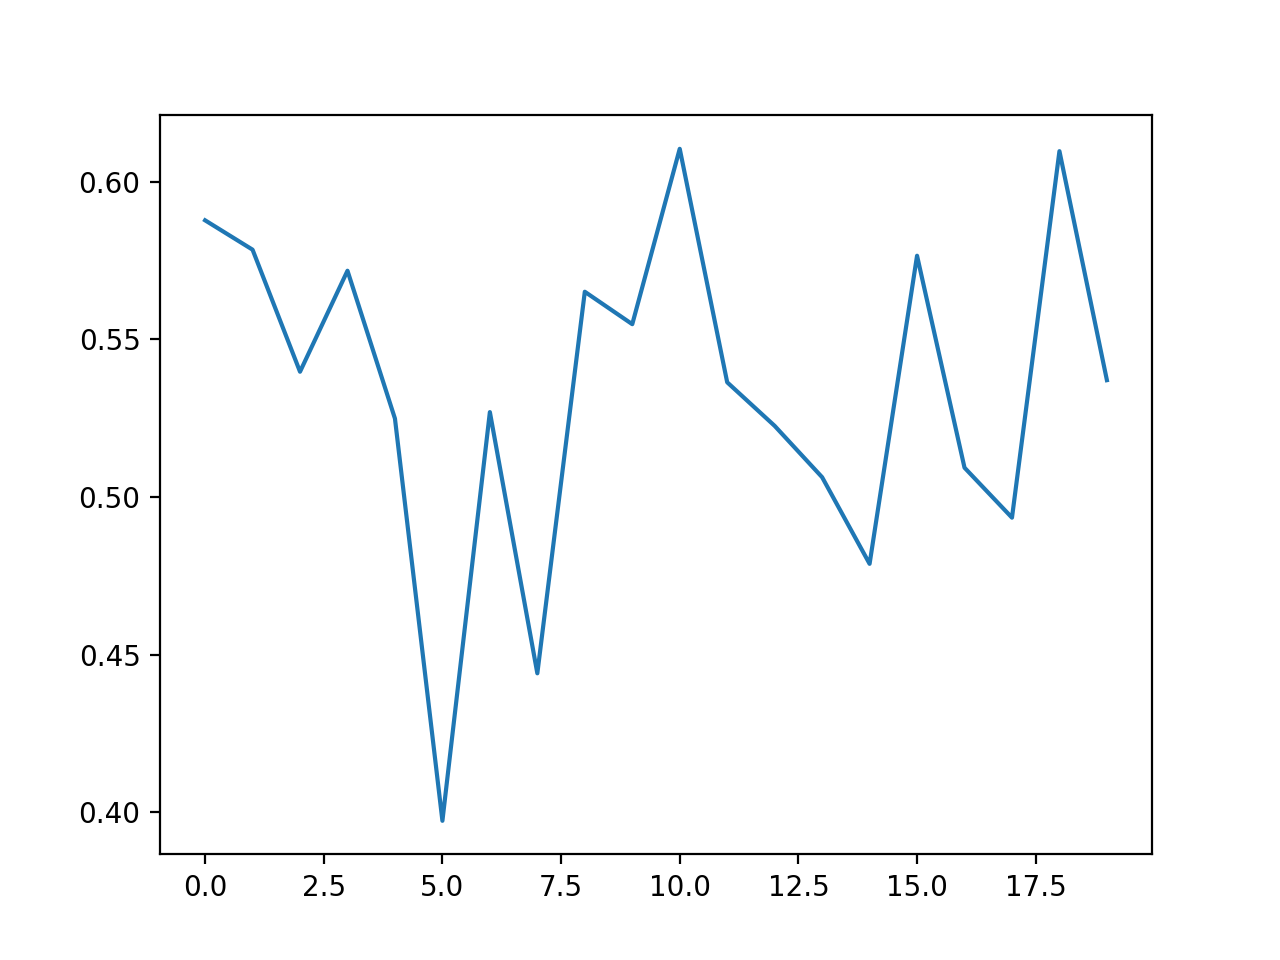

Average Watson NMI: 0.533576335840456


In [234]:
d = {'0':2,'2':0} 
running_NMI = []
for sub in range(len(best_paths)):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    
    gt = Z_seq[sub]
    
    sub_NMI = NMI(gt,decode_path[:-1])
    running_NMI.append(sub_NMI)
plt.close()
plt.plot(running_NMI)
plt.show()
print(f'Average Watson NMI: {np.mean(running_NMI)}')